In [24]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg



def findImgpts(images):
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)


def cal_undistort(img, objpts, imgpts):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#  pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100),binaryform=0):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    if binaryform == 0:
        
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        return color_binary
    
    elif binaryform == 1:
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        return combined_binary
    
def get_binaryimage(image):
    offset = 100
    
    # returns undistorted image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    
    #Use color transforms, gradients, etc., to create a 
    # thresholded combined binary image
    CombinedBinaryImage = pipeline(undistorted,s_thresh=(180, 255), sx_thresh=(20, 100),binaryform = 1)

    
    return CombinedBinaryImage

In [25]:
import cv2
import numpy as np
%matplotlib inline



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
SamCalibImg = glob.glob('../camera_cal/calibration*.jpg')

# Find object and image points
findImgpts(SamCalibImg)

True

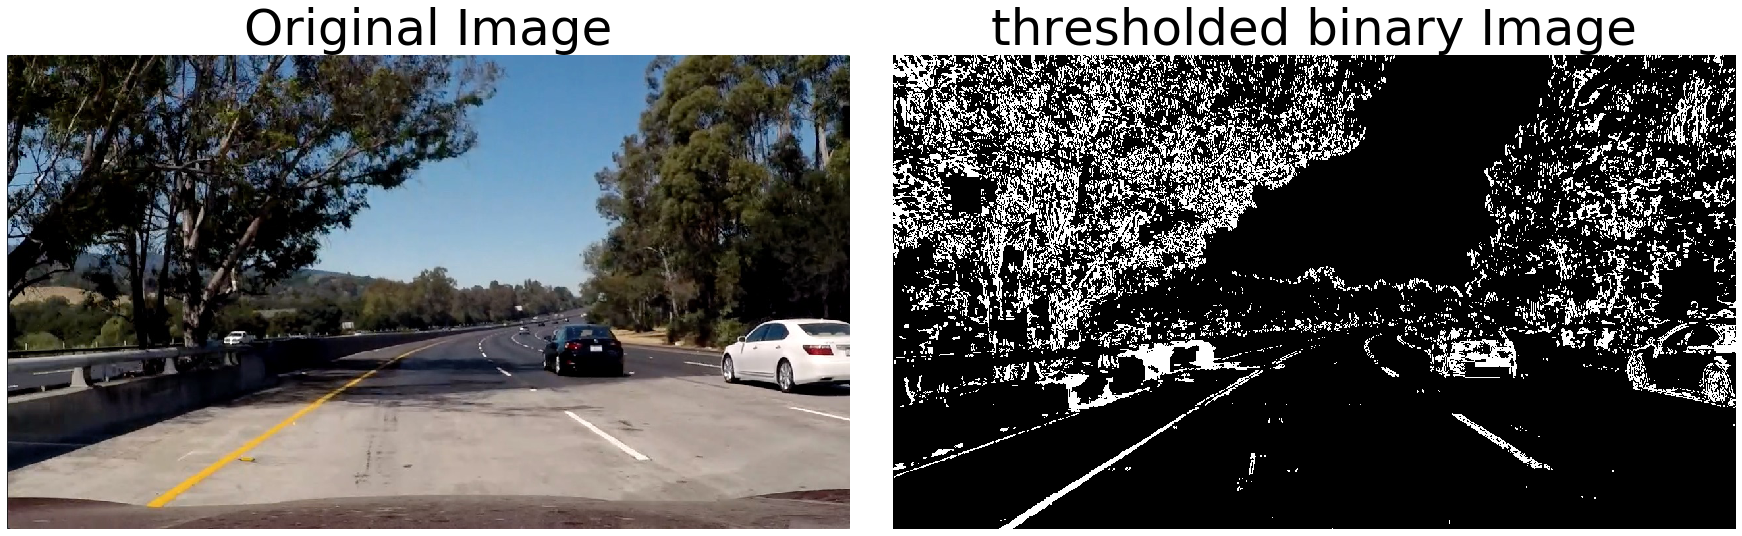

In [26]:
image = mpimg.imread('../test_images/test5.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)
ThresholdedcombinedBinaryImage = get_binaryimage(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_axis_off()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.set_axis_off()
ax2.imshow(ThresholdedcombinedBinaryImage, cmap='gray')
ax2.set_title('thresholded binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('test_distorted_image.jpg',image)
cv2.imwrite('thresholded_binary_Image.jpg',ThresholdedcombinedBinaryImage)